In [1]:
from glob import glob
from collections import defaultdict

import numpy as np
import cv2
from matplotlib import pyplot as plt

import colour
import skimage

In [2]:
plate_paths = glob("./data/carplates_example/*.npy")

In [3]:
base_colors = {
    "black": (0, 0, 0),
    "white": (255, 255, 255),
    "red": (255, 0, 0),
    "blue": (0, 0, 255),
    "yellow": (255, 152, 0),
}

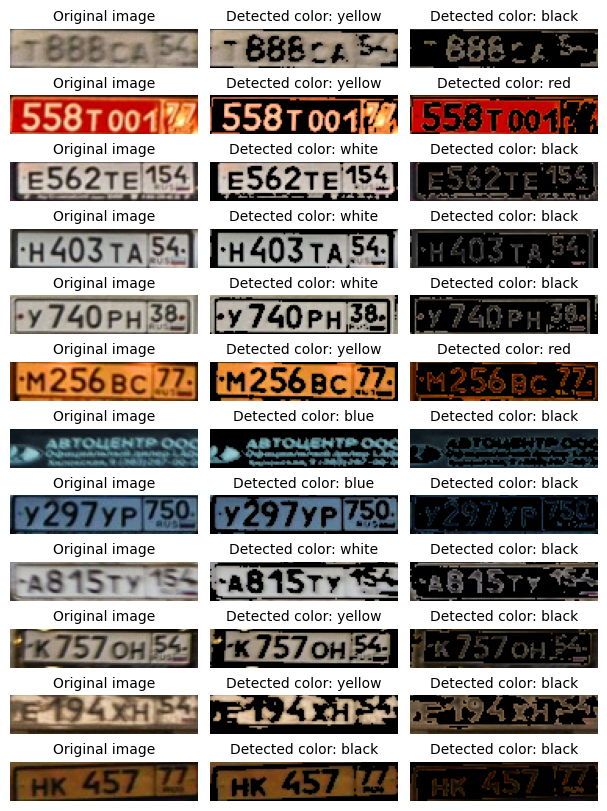

In [4]:
fig, axs = plt.subplots(len(plate_paths), 3, figsize=(6, 8), constrained_layout=True)
                        
for i, path in enumerate(plate_paths):
    # Read image
    img = np.load(path)
    img = cv2.resize(img, dsize=(120, 25), interpolation=cv2.INTER_CUBIC)
    w, h, _ = img.shape

    # img_blur = cv2.GaussianBlur(img,(5,5),0)
    img_lab = skimage.color.rgb2lab(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Create color pallete
    base_colors_lab = {}
    for name in base_colors:
        image = np.zeros((w, h, 3), np.uint8)
        image[:, :] = base_colors[name]
        base_colors_lab[name] = skimage.color.rgb2lab(image)

    # Treshold on two color 
    ret, otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    otsu_inv = cv2.bitwise_not(otsu)
    
    # Image mask
    img_otsu = cv2.bitwise_and(img, img, mask=otsu)
    img_otsu_inv = cv2.bitwise_and(img, img, mask=otsu_inv)

    # Calc best colour
    imagestat = {0: defaultdict(float), 1: defaultdict(float)}
    for name in base_colors_lab:
        delta_e = colour.delta_E(img_lab, base_colors_lab[name], method="CIE 2000")
        imagestat[0][name] = delta_e[otsu == 0].mean()
        imagestat[1][name] = delta_e[otsu != 0].mean()
    
    # Get colour resalt
    img_otsu_col = min(imagestat[1], key=imagestat[1].get)
    img_otsu_inv_col = min(imagestat[0], key=imagestat[0].get)

    # Plot result
    axs[i, 0].set_title('Original image', fontsize=10)
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')

    axs[i, 1].set_title(f'Detected color: {img_otsu_col}', fontsize=10)
    axs[i, 1].imshow(img_otsu)
    axs[i, 1].axis('off')

    axs[i, 2].set_title(f'Detected color: {img_otsu_inv_col}', fontsize=10)
    axs[i, 2].imshow(img_otsu_inv)
    axs[i, 2].axis('off')
    